# CSCI 1470 Lab #: Convolutional Autoencoder

In this lab, we will be introducing and getting familiar with the concept of convolutional autoencoders.

INSERT INSTRUCTION FOR ENVIRONMENT SETUP HERE

There are **2** checkpoints for this lab.

**Make sure to get all checkpoints checked off by your TA to get credit for this lab!**

## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.

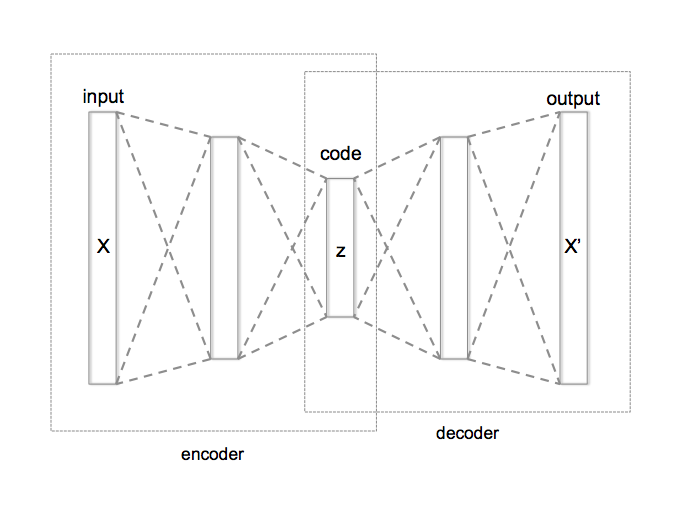

As we can see, the autoencoder is divided roughly in two parts: the encoder that encodes the input to a "code", or internal representation, that is reduced in dimensions, and the decoder that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function h(x)≈x. In other words, it is trying to learn an approximation to the identity function, so as to output x'  that is similar to x. This may sound like a pretty trivial task, why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code. E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

## Deconvolution (Transposed-Convolution)
Conceptually, deconvolution reverses the effects of convolution. Convolution with a stride of larger than 1 reduces the size of the input, while deconvolution can be described as a "fractional stride" convolution, it upscales the size of the input. Here's a visualisation.

#### Convolution with stride = 2:
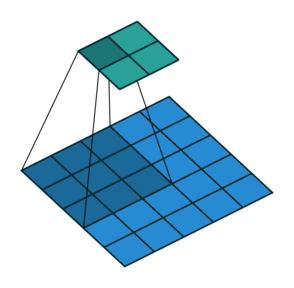

#### Deconvolution (convolution with fractional stride):
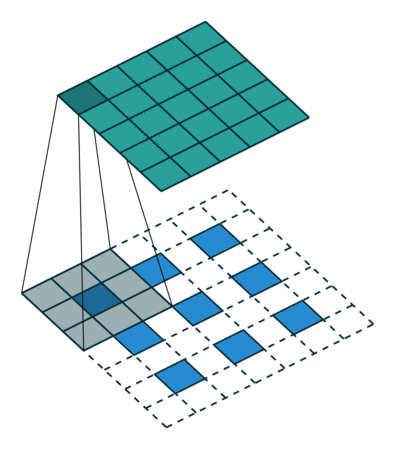

As we can see, deconvolution upscales the input. This is important for our decoder as its job is to upscale the encoded and compressed internal representation to its original size.
Concretely, this is how we implement deconvolution in tensorflow:

``` Python
tf.nn.conv2d_transpose(
    value, # input tensor: A 4-D Tensor of type float and shape [batch, height, width, in_channels]
    filter, # filter tensor: A 4-D Tensor with shape [height, width, output_channels, in_channels]
    output_shape, # A 1-D Tensor representing the output shape of the deconvolution op.
    strides, # A list of ints. The stride of the sliding window for each dimension of the input tensor.
    padding='SAME'
)
```

## Setup Code

In [8]:
import tensorflow as tf
import numpy as np
import math
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float32))
print(tf.__version__)
with tf.Session() as sess:
    x = [[1.,2.],[3.,4.]]
    l_result = sess.run([corrupt(x)])
    c_result = sess.run([corrupt(x)])
    assert(np.array(l_result).shape == (1,2,2))
    assert(np.array(c_result).shape == (1,2,2))

1.8.0


## Architecture Definition
We want to construct the following architecture:

(Due to the limitations of the rendering engine I'm using, there is a small inaccuracy: the connections in the decoder should be upscaling, not downscaling like in the encoder.)

**The weights for the encoder are the same matrices as for the decoder. E.x. the weight for first convolution in encoder is the same weight for the last deconvolution in the decoder.**

Shapes:

Layer | Shape of Output
--- | ---
Input | (batch_size, 28, 28, 1)
encoder_conv_1    | (batch_size, 14, 14, 10)
encoder_conv_2    | (batch_size, 7, 7, 10)  
encoder_conv_3    | (batch_size, 4, 4, 10)  
decoder_deconv_1  | (batch_size, 7, 7, 10)  
decoder_deconv_2  | (batch_size, 14, 14, 10)
decoder_deconv_3  | (batch_size, 28, 28, 1)
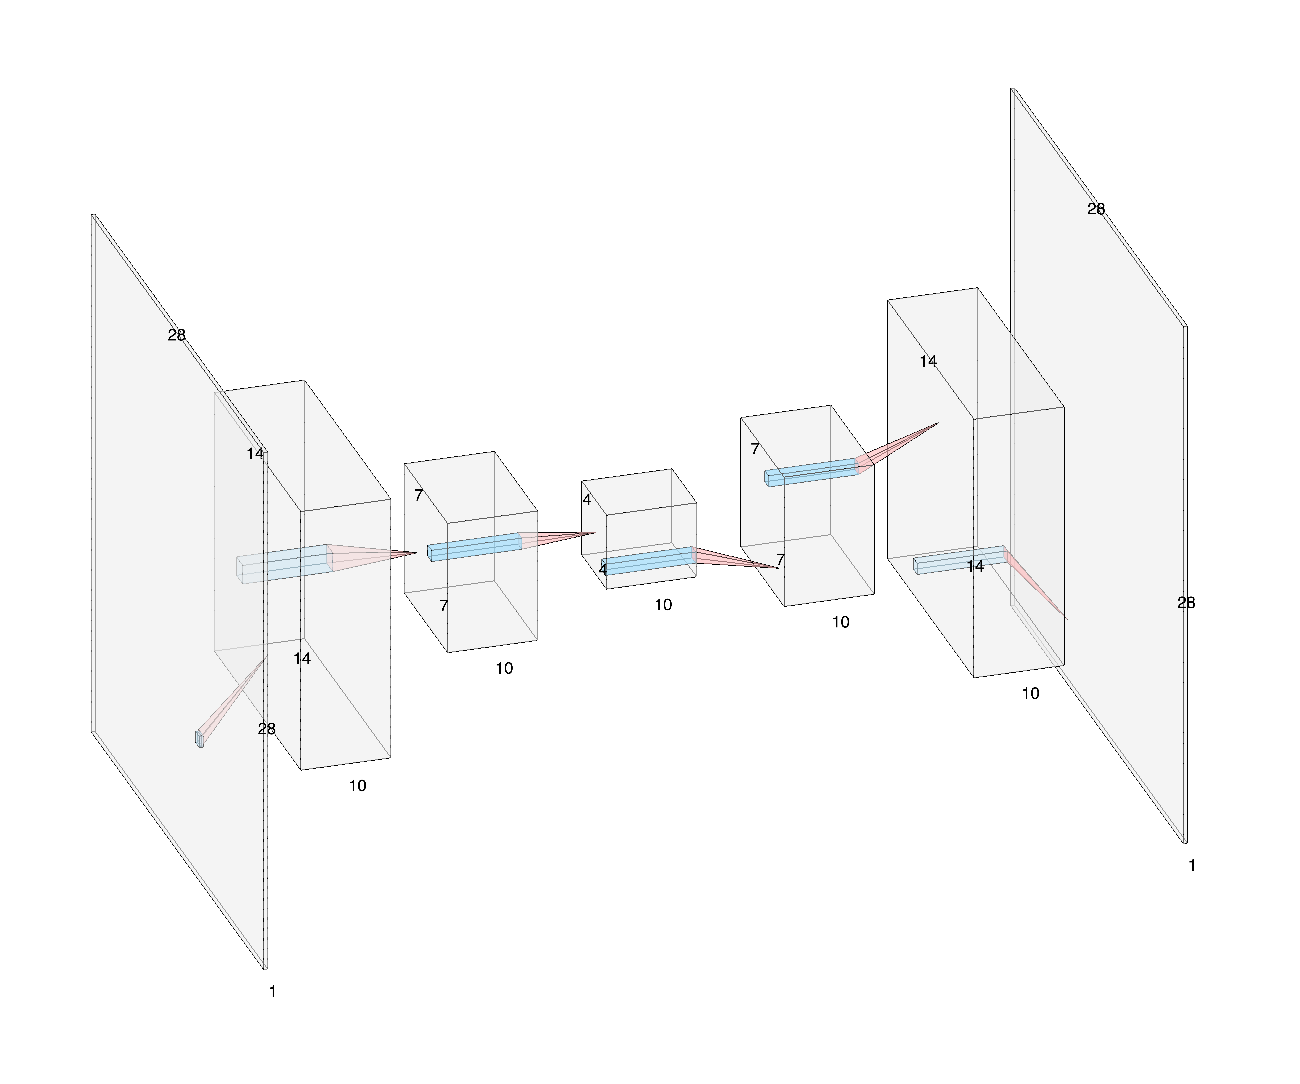

In [9]:
# filter sizes
e_filters=[1, 10, 10, 10]

In [10]:
# TODO Build the encoder
def encoder(x, n_filters):
    current_input = x
    # reshape if wrong shape
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x.get_shape()) == 4:
        x_tensor = x
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor
    # add noise
    current_input = corrupt(current_input)
    encoder_weights = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        # TODO create the weight variable 
        # (Hint: use random_uniform with maxval and minval +- 1.0 / math.sqrt(n_input))
        W = None
        # TODO create the bias variable (Hint: 1D with length of n_output)
        b = None
        # TODO create the conv layer (Hint: keep in mind the dimensions of the networks, SAME padding)
        conv = None
        # TODO add bias
        conv = None
        # TODO Activate with lrelu
        conv = None
        shapes.append(current_input.get_shape().as_list())
        encoder_weights.append(W)
        current_input = conv

    # return compressed representation, encoder weights, and shapes
    return conv, encoder_weights, shapes, x_tensor

In [11]:
# TODO Build the decoder
def decoder(x, z, encoder_weights, shapes):
    current_input = z
    decoder_weights = encoder_weights
    decoder_weights.reverse()
    shapes.reverse()
    for layer_i, shape in enumerate(shapes):
        # TODO create weight variable as the same as its encoder counterpart
        W = None
        b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]]))
        # TODO create the deconv layer (same stride and padding as encoder conv, think about output dimensions)
        deconv = None
        # TODO add bias
        deconv = None
        # TODO Activate with lrelu
        deconv = None
        current_input = deconv

    # return output
    return deconv

In [12]:
def autoencoder(n_filters):
    # Input placeholder
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    # build encoder
    z, e_weights, shapes, x_tensor = encoder(x, n_filters)
    # build decoder
    y = decoder(x, z, e_weights, shapes)
    # loss
    cost = tf.reduce_sum(tf.square(y - x_tensor))
    
    return {'x': x, 'z': z, 'y': y, 'cost': cost}

In [13]:
def test_mnist():
    """Test the convolutional autoencder using MNIST."""
    import tensorflow as tf
    import tensorflow.examples.tutorials.mnist.input_data as input_data
    import matplotlib.pyplot as plt

    # load MNIST
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    mean_img = np.mean(mnist.train.images, axis=0)
    ae = autoencoder(e_filters)

    learning_rate = 0.01
    
    # TODO create ADAM optimizer to minimise loss
    optimizer = None

    # We create a session to use the graph
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    # Fit all training data
    batch_size = 100
    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(mnist.train.num_examples // batch_size):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            train = np.array([img - mean_img for img in batch_xs])
            sess.run(optimizer, feed_dict={ae['x']: train})
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))

    # Plot example reconstructions
    n_examples = 10
    test_xs, _ = mnist.test.next_batch(n_examples)
    test_xs_norm = np.array([img - mean_img for img in test_xs])
    corrupted = sess.run(corrupt(test_xs_norm))
    recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(
            np.reshape(
                np.reshape(corrupted[example_i, ...], (784,)) + mean_img,
                (28, 28)))
        axs[1][example_i].imshow(
            np.reshape(
                np.reshape(recon[example_i, ...], (784,)) + mean_img,
                (28, 28)))
    plt.draw()

Due to inconsistencies in Jupyter kernals, you may have to run the code below a second time to get the desired results.

In [15]:
test_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


AttributeError: 'NoneType' object has no attribute 'get_shape'

This lab is written by Philip Xu (jianming_xu@brown.edu). Don't hesitate to email if there are questions about this lab!